_This notebook contains code and comments from Section 3.2 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

---

## 3.2 Combining predictions by weighting

First, we copy over the data generation stuff and the functions ``fit`` and ``predict_individual`` exactly as is from Section 3.1. (An alternate way to do this would be to import the functions from the notebook using the ``ipynb`` package).

In [18]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(600, noise=0.25, random_state=13)
X, Xval, y, yval = train_test_split(X, y, test_size=0.25)        # Set aside 25% of data for validation
Xtrn, Xtst, ytrn, ytst = train_test_split(X, y, test_size=0.25)  # Set aside a further 25% of data for hold-out test

In [2]:
# --- Some code to suppress warnings generated due to versioning changes in sklearn and scipy
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
# --- Can be removed at a future date

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

estimators = [('dt', DecisionTreeClassifier(max_depth=5)),
              ('svm', SVC(gamma=1.0, C=1.0, probability=True)),
              ('gp', GaussianProcessClassifier(RBF(1.0))),
           	  ('3nn', KNeighborsClassifier(n_neighbors=3)),
              ('rf',RandomForestClassifier(max_depth=3, n_estimators=25)),
              ('gnb', GaussianNB())]

def fit(estimators, X, y):
    for model, estimator in estimators:
        estimator.fit(X, y)
    return estimators

In [3]:
import numpy as np

def predict_individual(X, estimators, proba=False):
    n_estimators = len(estimators)
    n_samples = X.shape[0] 

    y = np.zeros((n_samples, n_estimators))
    for i, (model, estimator) in enumerate(estimators):
        if proba:
            y[:, i] = estimator.predict_proba(X)[:, 1]  
        else:
            y[:, i] = estimator.predict(X)              
    return y

Fit the estimators to the synthetic data set.

In [4]:
estimators = fit(estimators, Xtrn, ytrn)

---

### 3.2.1	Majority Vote

**Listing 3.3**: Combine predictions using majority vote. 
The listing below combines the individual predictions y_individual from a heterogeneous set of base estimators using majority voting. Note that since the weights of the base estimators are all equal, we do not explicitly compute them.

In [5]:
from scipy.stats import mode

def combine_using_majority_vote(X, estimators):
    y_individual = predict_individual(X, estimators, proba=False)
    y_final = mode(y_individual, axis=1)
    return y_final[0].reshape(-1, )

In [6]:
from sklearn.metrics import accuracy_score
ypred = combine_using_majority_vote(Xtst, estimators)
tst_err = 1 - accuracy_score(ytst, ypred)
tst_err

0.03539823008849563

---
### 3.2.2 Accuracy weighting

**Listing 3.4**: Combine using accuracy weighting

Accuracy weighting is a performance-based weighting strategy, where higher-performing base estimators in the ensemble are assigned higher weights, so that they contribute more to the final prediction.

Once we have trained each base classifier, we evaluate its performance on a validation set. Let $\alpha_t$ be the validation accuracy of the $t$-th classifier, $H_t$. The weight of each base classifier is then computed as $w_t =  \frac{\alpha_t}{\sum_{t=1}^m \, \alpha_t}$.

The denominator is a normalization term: the sum of all the individual validation accuracies. This computation ensures that a classifier’s weight is proportional to its accuracy and all the weights sum to 1. 

In [7]:
def combine_using_accuracy_weighting(X, estimators, Xval, yval):
    n_estimators = len(estimators)
    yval_individual = predict_individual(Xval, estimators, proba=False)
    
    wts = [accuracy_score(yval, yval_individual[:, i]) 
       for i in range(n_estimators)] 
    wts /= np.sum(wts)

    ypred_individual = predict_individual(X, estimators, proba=False)
    y_final = np.dot(ypred_individual, wts) 

    return np.round(y_final)

In [8]:
ypred = combine_using_accuracy_weighting(Xtst, estimators, Xval, yval)
tst_err = 1 - accuracy_score(ytst, ypred)
tst_err

0.03539823008849563

---

### 3.2.3 Entropy weighting

The entropy weighting approach is another performance-based weighting approach, except that it uses entropy as the evaluation metric to judge the value of each base estimator. [Entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) is a measure of uncertainty or impurity in a set; a more disorderly set will have higher entropy. 

**Listing 3.5** Computing entropy.

In [9]:
def entropy(y):
    _, counts = np.unique(y, return_counts=True) 
    p = np.array(counts.astype('float') / len(y))
    ent = -p.T @ np.log2(p) 

    return ent

**Listing 3.6**: Combine using entropy weighting

Let $E_t$ be the validation entropy of the $t$-th classifier, $H_t$. The weight of each base classifier is then computed as \frac{(1/E_t)}{\sum_{t=1}^m \, (1/E_t)}$. Contrast this with accuracy weighting, and observe that the entropies are inverted. This is because lower entropies are desirable, much like higher accuracies are desirable in a model.

In [10]:
def combine_using_entropy_weighting(X, estimators, Xval, yval):
    n_estimators = len(estimators)
    yval_individual = predict_individual(Xval, estimators, proba=False)
    
    wts = [1/entropy(yval_individual[:, i]) 
           for i in range(n_estimators)]
    wts /= np.sum(wts)

    ypred_individual = predict_individual(X, estimators, proba=False)
    y_final = np.dot(ypred_individual, wts)
    
    return np.round(y_final)

In [11]:
ypred = combine_using_entropy_weighting(Xtst, estimators, Xval, yval)
tst_err = 1 - accuracy_score(ytst, ypred)
tst_err

0.03539823008849563

--- 
### 3.2.4	Dempster-Shafer combination

[Dempster-Shafer Theory](https://en.wikipedia.org/wiki/Dempster%E2%80%93Shafer_theory) is a generalization of probability theory that supports reasoning under uncertainty and with incomplete knowledge. While the foundations of DST are beyond the scope of this book, the theory itself provides a way to fuse beliefs and evidence from multiple sources into one single belief. 

DST uses a number between 0 and 1 to indicate belief in a proposition, such as “the test example x belongs to Class 1”.  This number is known as a basic probability assignment (BPA) and expresses the certainty that the text example x belongs to Class 1. BPA values closer to 1 characterize decisions made with more certainty. The BPA allows us to translate an estimator’s confidence to a belief over what the true label is.

**Listing 3.7**: Combining using Dempster-Shafer

In [12]:
def combine_using_Dempster_Schafer(X, estimators):
    p_individual = predict_individual(X, estimators, proba=True)
    bpa0 = 1.0 - np.prod(p_individual, axis=1) - 1e-6
    bpa1 = 1.0 - np.prod(1.0 - p_individual, axis=1) - 1e-6

    belief = np.vstack([bpa0 / (1 - bpa0), bpa1 / (1 - bpa1)]).T
    y_final = np.argmax(belief, axis=1)
    return y_final

In [13]:
ypred = combine_using_Dempster_Schafer(Xtst, estimators)
tst_err = 1 - accuracy_score(ytst, ypred)
tst_err

0.03539823008849563

---
**Unlisted**: Logarithmic opinion pooling (LOP), first described in [Heskes98](https://papers.nips.cc/paper/1413-selecting-weighting-factors-in-logarithmic-opinion-pools.pdf).

In [14]:
def combine_using_LOP(X, estimators, Xval, yval):
    n_estimators = len(estimators)
    yval_individual = predict_individual(Xval, estimators, proba=False)
    wts = [1 - accuracy_score(yval, yval_individual[:, i]) for i in range(n_estimators)]
    wts /= np.sum(wts)

    p_individual = predict_individual(X, estimators, proba=True)
    p_LOP = np.exp(np.dot(np.log(p_individual), wts))
    return np.round(p_LOP)

---

### Visualizing the decision boundaries of all 4 weighting methods

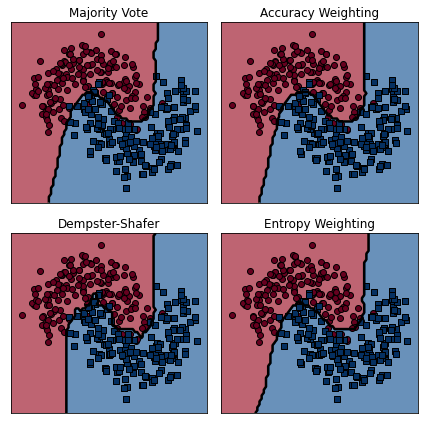

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from visualization import plot_2d_classifier, get_colors


combination_methods = [('Majority Vote', combine_using_majority_vote),
                       ('Dempster-Shafer', combine_using_Dempster_Schafer),
                       ('Accuracy Weighting', combine_using_accuracy_weighting),
                       ('Entropy Weighting', combine_using_entropy_weighting)]
# ('Logarithmic Opinion Pool', combine_using_LOP)]

nrows, ncols = 2, 2
cm = get_colors(colormap='RdBu')

# Init plotting
xMin, xMax = Xtrn[:, 0].min() - 0.25, Xtrn[:, 0].max() + 0.25
yMin, yMax = Xtrn[:, 1].min() - 0.25, Xtrn[:, 1].max() + 0.25
xMesh, yMesh = np.meshgrid(np.arange(xMin, xMax, 0.05),
                           np.arange(yMin, yMax, 0.05))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6, 6))

for i, (method, combiner) in enumerate(combination_methods):
    c, r = divmod(i, 2)
    if i < 2:
        zMesh = combiner(np.c_[xMesh.ravel(), yMesh.ravel()], estimators)
        ypred = combiner(Xtst, estimators)
    else:
        zMesh = combiner(np.c_[xMesh.ravel(), yMesh.ravel()], estimators, Xval, yval)
        ypred = combiner(Xtst, estimators, Xval, yval)
    zMesh = zMesh.reshape(xMesh.shape)

    ax[r, c].contourf(xMesh, yMesh, zMesh, cmap='RdBu', alpha=0.65)
    ax[r, c].contour(xMesh, yMesh, zMesh, [0.5], colors='k', linewidths=2.5)
    ax[r, c].scatter(Xtrn[ytrn == 0, 0], Xtrn[ytrn == 0, 1], marker='o', c=cm[0], edgecolors='k')
    ax[r, c].scatter(Xtrn[ytrn == 1, 0], Xtrn[ytrn == 1, 1], marker='s', c=cm[1], edgecolors='k')

    # tst_err = 1 - accuracy_score(ytst, ypred)
    # title = '{0} (err = {1:4.2f}%)'.format(method, tst_err*100) 
    title = '{0}'.format(method) 

    ax[r, c].set_xticks([])
    ax[r, c].set_yticks([])
    ax[r, c].set_title(title)

fig.tight_layout()
plt.savefig('./figures/CH03_F10_Kunapuli.png', dpi=300, bbox_inches='tight');